In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

由于批处理输入，需要将尺寸为 B 的输入reshape为 B x Nin，其中Nin为1。你可以使用unsqueeze轻松地做到这一点：

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # 对数据维度进行扩充,第二个参数为0数据为行方向扩，为1列方向扩
t_u = torch.tensor(t_u).unsqueeze(1) 

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]          #划分训练集和验证集
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices        # 划分结果是随机的

(tensor([ 6,  3,  8,  2,  7, 10,  4,  5,  1]), tensor([9, 0]))

In [4]:
t_u_train = t_u[train_indices]    #获得了可用于从数据张量构建训练集和验证集的索引
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train      # 更改输入使梯度差别不要太大
t_un_val = 0.1 * t_u_val

train_indices,t_un_train, t_un_val

(tensor([ 6,  3,  8,  2,  7, 10,  4,  5,  1]),
 tensor([[3.3900],
         [8.1900],
         [4.8400],
         [5.8200],
         [2.1800],
         [6.8400],
         [5.6300],
         [4.8900],
         [5.5900]]),
 tensor([[6.0400],
         [3.5700]]))

nn.Linear的构造函数接受三个参数：输入要素的数量，输出要素的数量以及线性模型是否包含偏差（此处默认为True）：

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>    #参数是输入大小，输出大小和默认为True的偏差
linear_model(t_un_val)

tensor([[1.6076],
        [0.8379]], grad_fn=<AddmmBackward>)

我们有一个带有一个输入和一个输出功能的nn.Linear实例。这只需要一种权重和一种偏置：

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.3116]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.2745], requires_grad=True)

In [8]:
x = torch.ones(1)    #用一些输入来调用模块
linear_model(x)

tensor([0.0371], grad_fn=<AddBackward0>)

批处理输入：

In [9]:
x = torch.ones(10, 1)      #同时产生一批多个输入的输出
linear_model(x)

tensor([[0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371],
        [0.0371]], grad_fn=<AddmmBackward>)

更新原来的训练代码。首先，将之前的手工模型替换为nn.Linear(1,1)，然后将线性模型参数传递给优化器：

In [10]:
linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(
    linear_model.parameters(),   # 将线性模型参数传递给优化器
    lr=1e-2)

In [11]:
linear_model.parameters()       # 使用parameters方法获取任何nn.Module或其子模块的参数列表

<generator object Module.parameters at 0x0000020EE0A80350>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9055]], requires_grad=True),
 Parameter containing:
 tensor([0.0870], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)    # 现在传递模型，而不是传递单个参数
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) 
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # 损失函数也已传入。稍后我们将使用它。
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 194.2683, Validation loss 76.1820
Epoch 1000, Training loss 3.5047, Validation loss 6.9754
Epoch 2000, Training loss 2.7475, Validation loss 4.9816
Epoch 3000, Training loss 2.7255, Validation loss 4.7282

Parameter containing:
tensor([[5.3266]], requires_grad=True)
Parameter containing:
tensor([-16.6950], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 我们采用均方误差MSE代替了之前自己创建的损失函数
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 354.2063, Validation loss 167.6387
Epoch 1000, Training loss 3.5332, Validation loss 7.0287
Epoch 2000, Training loss 2.7484, Validation loss 4.9875
Epoch 3000, Training loss 2.7255, Validation loss 4.7291

Parameter containing:
tensor([[5.3264]], requires_grad=True)
Parameter containing:
tensor([-16.6935], requires_grad=True)


 nn提供了一种通过nn.Sequential容器连接模块的简单方法：

In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # 我们任意选择了13。我们想要一个与其他张量形状不同的数字。
            nn.Tanh(),
            nn.Linear(13, 1)) # 但是，这里的13必须匹配第一个大小。

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]     # 调用model.parameters()可以得到第一线性模块和第二线性模块中的权重和偏差

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():   # 利用named_parameters检查由几个子模块组成的模型的参数，通过其名称识别参数。
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict               # 使用OrderedDict来明确层的顺序并强调这个顺序的重要性
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():   #  获得子模块的更多解释性名称
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias       # 通过使用子模块作为属性来访问特定的参数：

Parameter containing:
tensor([-0.0257], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # 为了稳定性，我们降低了学习率

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 225.2290, Validation loss 93.6895
Epoch 1000, Training loss 4.9394, Validation loss 4.3804
Epoch 2000, Training loss 4.2771, Validation loss 13.0048
Epoch 3000, Training loss 2.1234, Validation loss 8.4701
Epoch 4000, Training loss 1.6451, Validation loss 6.9847
Epoch 5000, Training loss 1.5276, Validation loss 6.9095
output tensor([[15.0284],
        [ 1.9817]], grad_fn=<AddmmBackward>)
answer tensor([[13.0000],
        [ 0.5000]])
hidden tensor([[  0.5252],
        [  0.1227],
        [ -0.2252],
        [  0.4960],
        [ 14.1398],
        [ 12.6216],
        [ 13.7558],
        [-14.4982]])


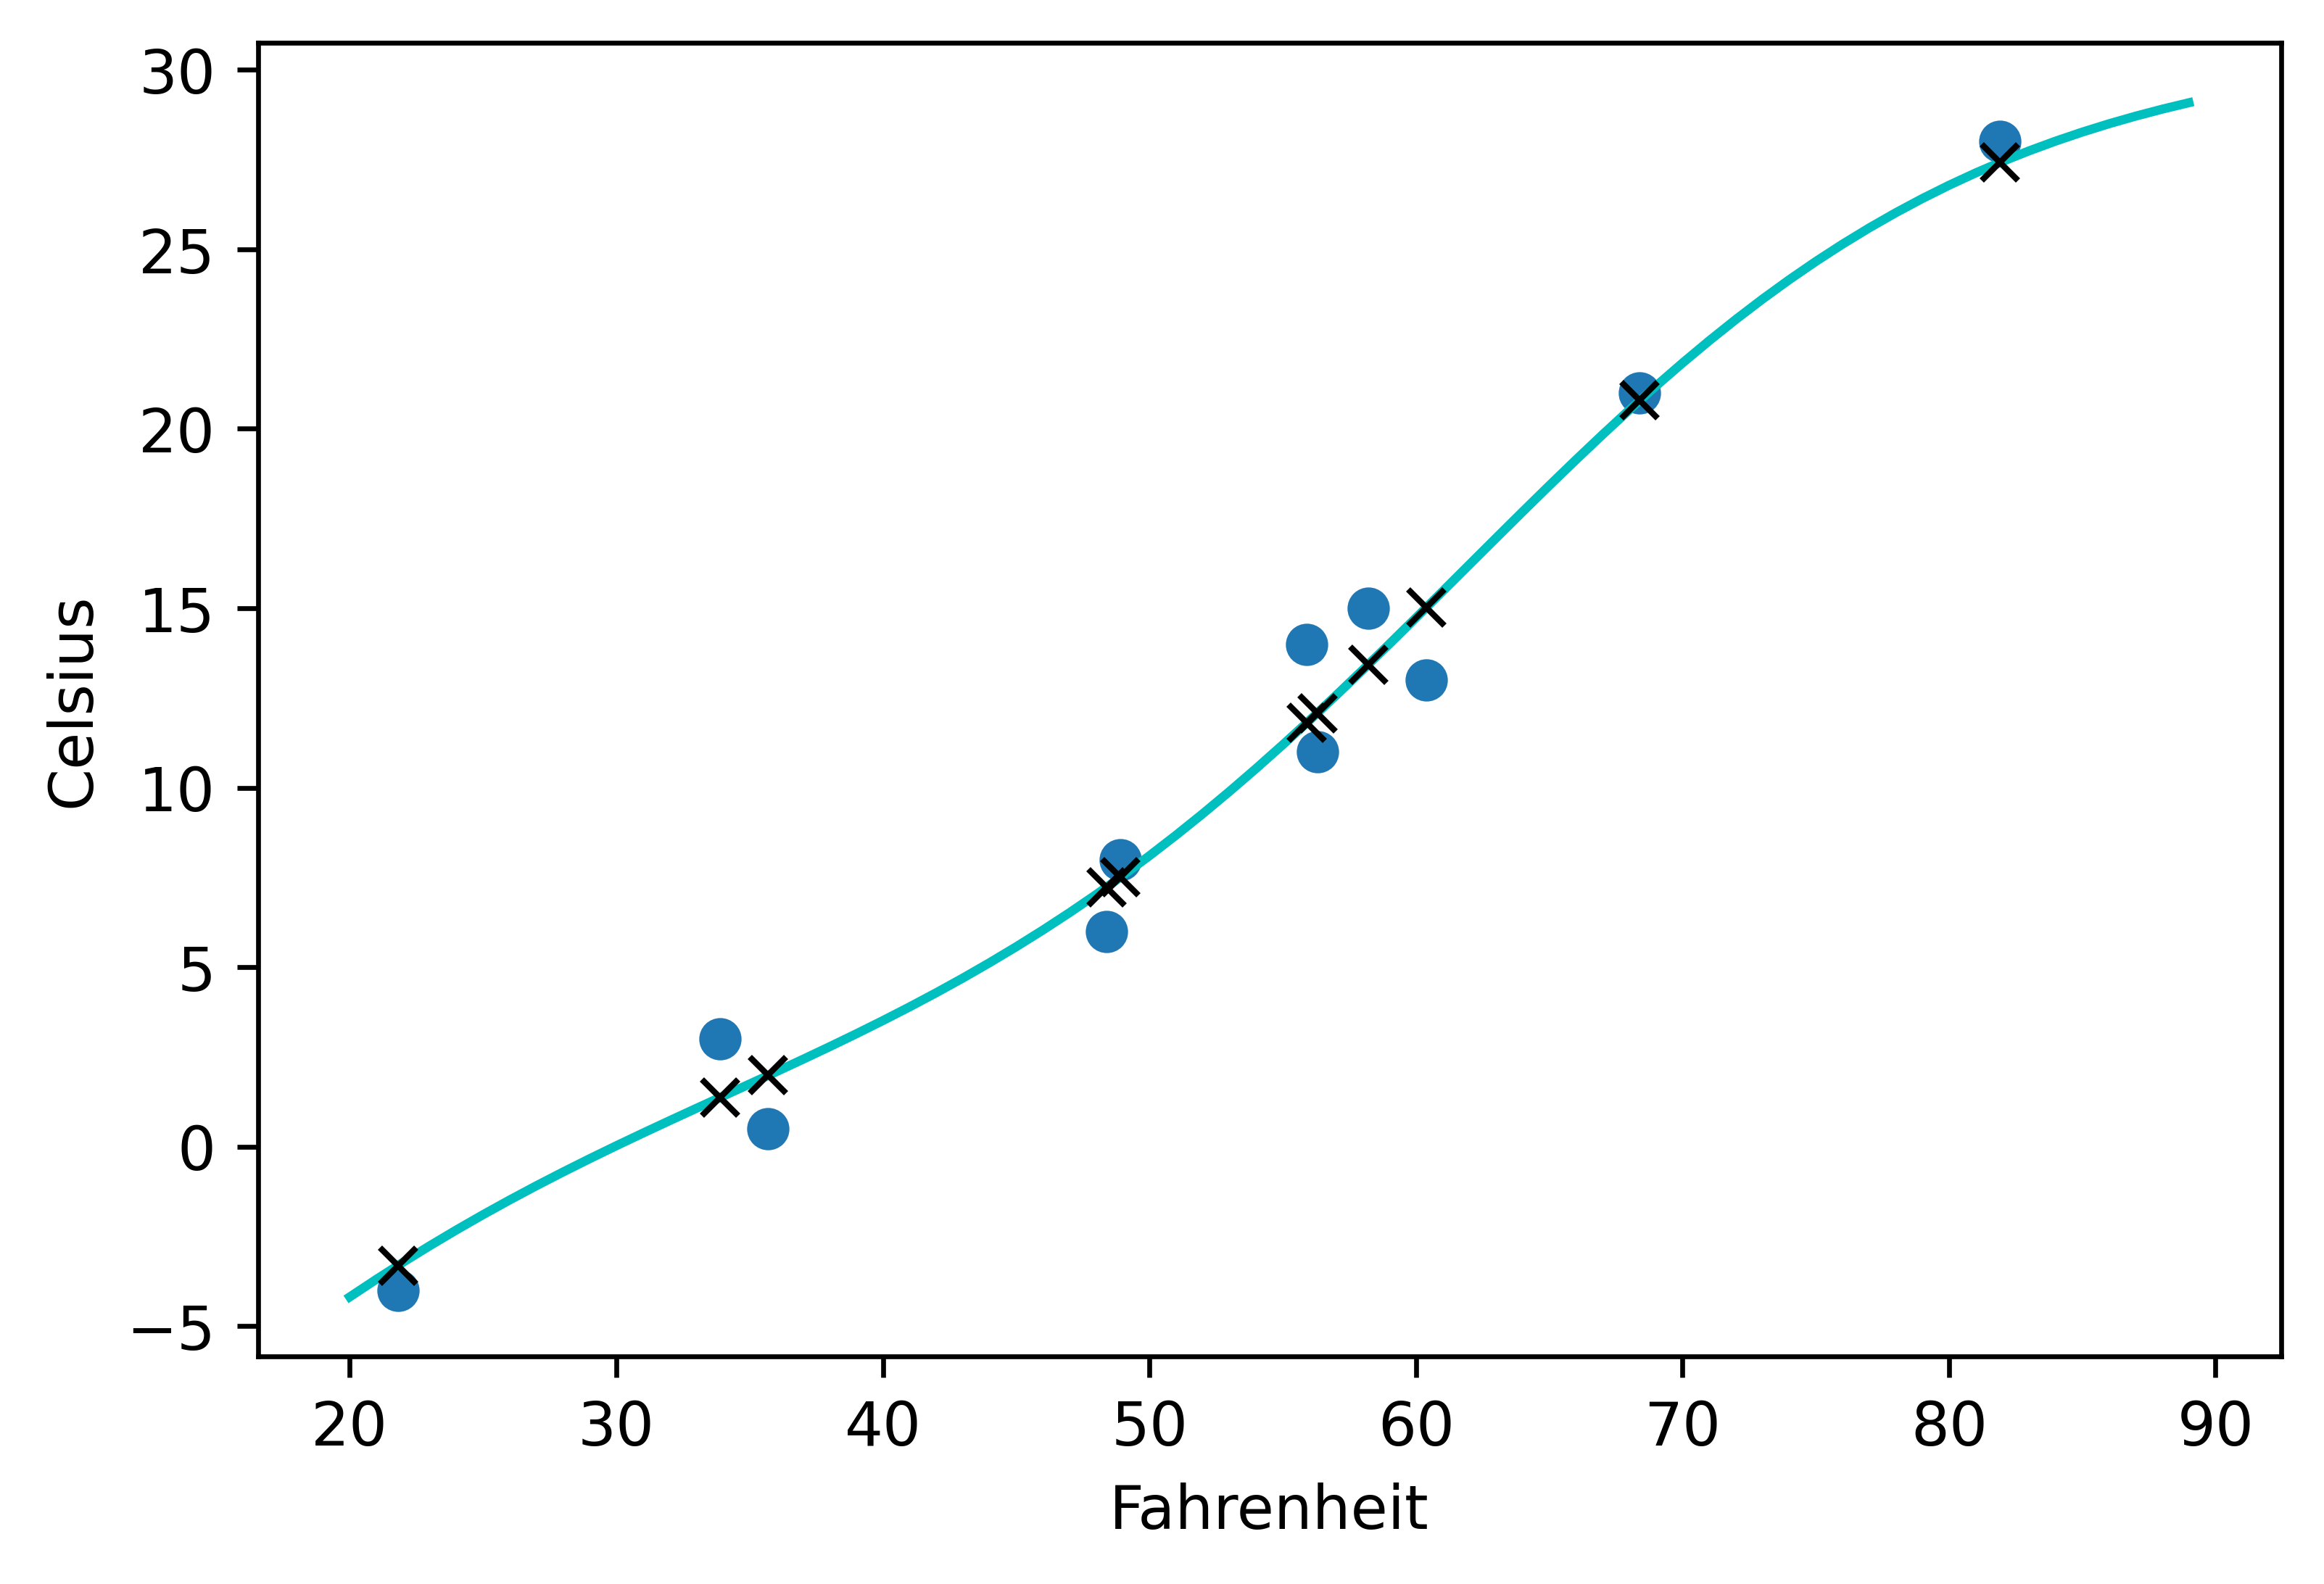

In [24]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 208.8718, Validation loss 84.0952
Epoch 1000, Training loss 48.2927, Validation loss 33.2012
Epoch 2000, Training loss 28.5057, Validation loss 21.2322
Epoch 3000, Training loss 16.1180, Validation loss 12.1147
Epoch 4000, Training loss 9.6459, Validation loss 7.3459
Epoch 5000, Training loss 6.7486, Validation loss 5.6713


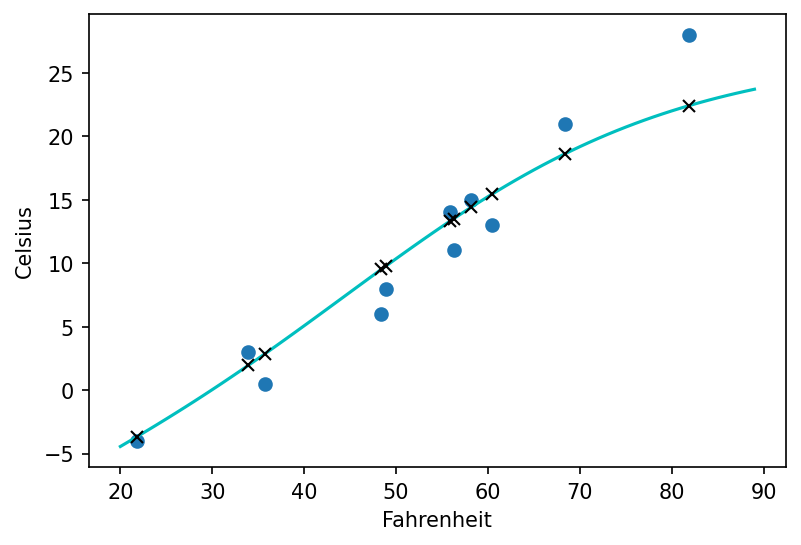

In [25]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
